# EECS 6893 Final Project AIS Image Classifier Model

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.4


We will use IMG_SIZE of 224 x 224 and BATCH_SIZE of 32.

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
IMG_SIZE = 224
SHUFFLE_SIZE = 1000
EPOCHS = 10

### Utility functions

In [3]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [4]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

## Download data from S3 bucket

In [5]:
# S3 and local directories
train_s3_dir = 's3://eecse-6893-track-images/train/'
valid_s3_dir = 's3://eecse-6893-track-images/validate/'
test_s3_dir = 's3://eecse-6893-track-images/test/'

train_dir = 'content/eecse-6893-track-images/train'
valid_dir = 'content/eecse-6893-track-images/validate'
test_dir = 'content/eecse-6893-track-images/test'

## Prepare training and validation data of mobility pattern images

In [6]:
# Prepare dataset of mobility pattern images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_labels = [ 'Anchored', 'Fishing', 'Moored', 'Underway' ]

# Using the keras preprocessing utilities here instead of tf.data

# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 1273 images belonging to 4 classes.
Found 532 images belonging to 4 classes.


train data batch shape: (8, 224, 224, 3)
train labels batch shape: (8, 4)


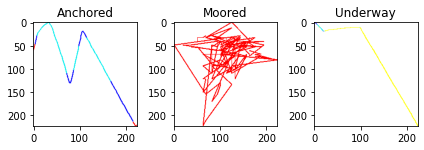

valid data batch shape: (8, 224, 224, 3)
valid labels batch shape: (8, 4)


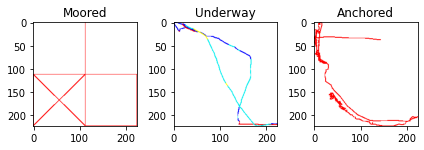

In [11]:
from itertools import compress
# check train data
fig=plt.figure()
cols=3
for train_data_batch, train_labels_batch in train_generator:
    print('train data batch shape:', train_data_batch.shape)
    print('train labels batch shape:', train_labels_batch.shape)
    fig.add_subplot(1, cols, 1)
    plt.imshow(train_data_batch[3])
    plt.title(list(compress(image_labels, train_labels_batch[3]))[0])
    fig.add_subplot(1, cols, 2)
    plt.imshow(train_data_batch[5])
    plt.title(list(compress(image_labels, train_labels_batch[5]))[0])
    fig.add_subplot(1, cols, 3)
    plt.imshow(train_data_batch[7])
    plt.title(list(compress(image_labels, train_labels_batch[7]))[0])
    break

fig.tight_layout()    
plt.show()

# check validation data
fig=plt.figure()
cols=3
for valid_data_batch, valid_labels_batch in valid_generator:
    print('valid data batch shape:', valid_data_batch.shape)
    print('valid labels batch shape:', valid_labels_batch.shape)
    fig.add_subplot(1, cols, 1)
    plt.imshow(valid_data_batch[3])
    plt.title(list(compress(image_labels, valid_labels_batch[3]))[0])
    fig.add_subplot(1, cols, 2)
    plt.imshow(valid_data_batch[5])
    plt.title(list(compress(image_labels, valid_labels_batch[5]))[0])
    fig.add_subplot(1, cols, 3)
    plt.imshow(valid_data_batch[7])
    plt.title(list(compress(image_labels, valid_labels_batch[7]))[0])
    break

fig.tight_layout()    
plt.show()

## Train Model1 - Simple CNN

In [12]:
# Train model

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(len(image_labels), activation='softmax'))
model.summary()

# compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit_generator(
      train_generator,
      epochs=EPOCHS,
      validation_data=valid_generator)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 760384)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3041540   
Total params: 3,065,124
Trainable params: 3,065,124
Non-trainable params: 0
______________________________________________

### Plot accuracy/loss per epoch

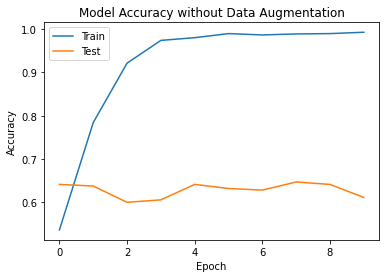

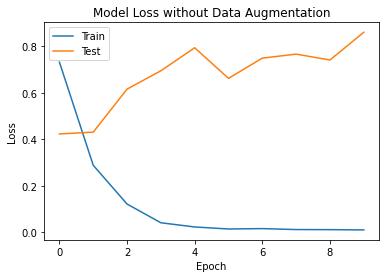

In [13]:
# Plot accuracy/loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy without Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss without Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict on test data and calculate metrics

In [14]:
# Predict on test data and calculate metrics
import os
y_true = []
y_pred = []

for label in image_labels:  
    # Predict test images of label
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    i = 0
    for f in tc_files:
        fpath = os.path.join(test_imgs_path, f)
        img = load_and_preprocess_image(fpath)
        im_batch = tf.expand_dims(img, 0)
        # make predictions
        batch_pred = model.predict(im_batch) # returns a list of predictions
        pred = batch_pred[0] 
        i = i + 1
        pred_label = image_labels[tf.argmax(pred)]
        y_true.append(label)
        y_pred.append(pred_label)

### Confusion Matrix

In [15]:
import sklearn.metrics
import numpy
#confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred, labels=image_labels)
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [16]:
classification_report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names=image_labels
)
print(classification_report)

              precision    recall  f1-score   support

    Anchored       0.84      0.70      0.77       108
     Fishing       0.56      0.39      0.46        49
      Moored       0.40      0.81      0.54        31
    Underway       0.69      0.71      0.70        76

    accuracy                           0.66       264
   macro avg       0.62      0.65      0.62       264
weighted avg       0.70      0.66      0.66       264



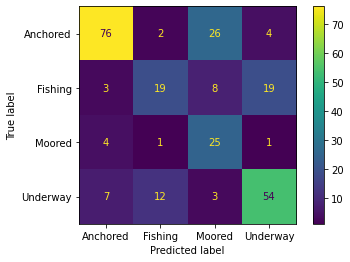

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_labels)
disp.plot()
plt.show()

### Accuracy, Precision, F1, and Recall

In [18]:
print('Precision score:', sklearn.metrics.precision_score(y_true, y_pred, average='macro', labels=image_labels))
print('Accuracy score:', sklearn.metrics.accuracy_score(y_true, y_pred))
print('Recall score:', sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print('F1 score:', sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

Precision score: 0.6247003681538785
Accuracy score: 0.6590909090909091
Recall score: 0.6590909090909091
F1 score: 0.6640461886902194


### ROC Curves

ROC AUC score: 0.7703084806379096


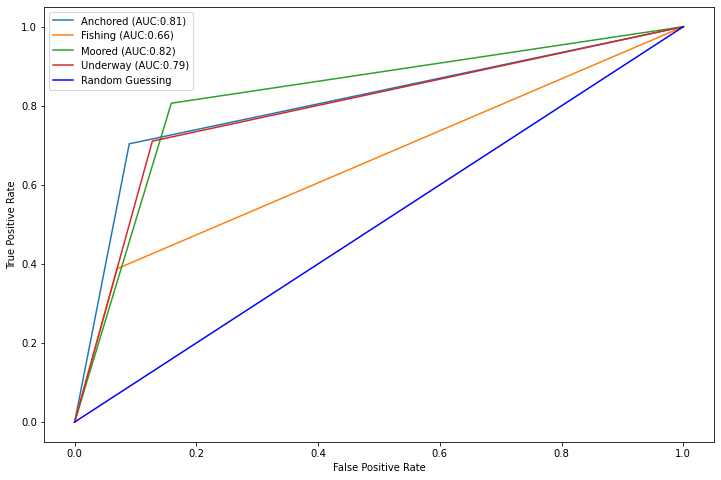

In [19]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(image_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Data augmentation

In [65]:
# 2a 4 Data Augmentation
train_datagen_du = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
train_generator_du = train_datagen_du.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=20)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=20)

Found 1273 images belonging to 4 classes.
Found 532 images belonging to 4 classes.


train augmented data batch shape: (20, 224, 224, 3)
train augmented labels batch shape: (20, 4)


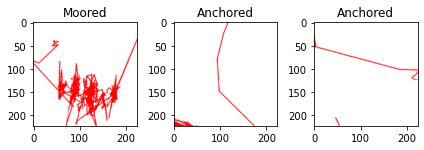

In [66]:
from itertools import compress
# check train data post data augmentation
fig=plt.figure()
cols=3
for train_data_batch, train_labels_batch in train_generator_du:
    print('train augmented data batch shape:', train_data_batch.shape)
    print('train augmented labels batch shape:', train_labels_batch.shape)
    fig.add_subplot(1, cols, 1)
    plt.imshow(train_data_batch[3])
    plt.title(list(compress(image_labels, train_labels_batch[3]))[0])
    fig.add_subplot(1, cols, 2)
    plt.imshow(train_data_batch[5])
    plt.title(list(compress(image_labels, train_labels_batch[5]))[0])
    fig.add_subplot(1, cols, 3)
    plt.imshow(train_data_batch[7])
    plt.title(list(compress(image_labels, train_labels_batch[7]))[0])
    break

fig.tight_layout()    
plt.show()

## Train Model2 - Simple CNN model trained with augmented data
Simple CNN model is trained with augmened data

In [67]:
# Train model with data augmentation
model_du = models.Sequential()
model_du.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_du.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_du.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_du.add(layers.MaxPooling2D())
model_du.add(layers.Flatten())
model_du.add(layers.Dense(len(image_labels), activation='softmax'))
model_du.summary()

# compile
model_du.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_du = model_du.fit_generator(
      train_generator_du,
      epochs=EPOCHS,
      validation_data=valid_generator)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 220, 220, 32)      4640      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 218, 218, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 760384)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 3041540   
Total params: 3,065,124
Trainable params: 3,065,124
Non-trainable params: 0
____________________________________________

### Plot accuracy/loss per epoch

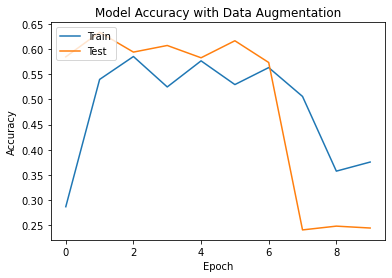

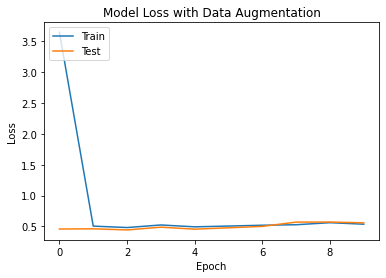

In [68]:
# Plot accuracy/loss simple CNN trained with data augmnetation
plt.plot(history_du.history['accuracy'])
plt.plot(history_du.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_du.history['loss'])
plt.plot(history_du.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict using Simple CNN model trained with augmented data

In [24]:
# Predict on test data and calculate metrics
import os
y_true = []
y_pred = []

for label in image_labels:  
    # Predict test images of label
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    i = 0
    for f in tc_files:
        fpath = os.path.join(test_imgs_path, f)
        img = load_and_preprocess_image(fpath)
        im_batch = tf.expand_dims(img, 0)
        # make predictions
        batch_pred = model_du.predict(im_batch) # returns a list of predictions
        pred = batch_pred[0] 
        i = i + 1
        pred_label = image_labels[tf.argmax(pred)]
        y_true.append(label)
        y_pred.append(pred_label)

### Confusion matrix

In [25]:
import sklearn.metrics
import numpy
#confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred, labels=image_labels)
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [26]:
classification_report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names=image_labels
)
print(classification_report)

              precision    recall  f1-score   support

    Anchored       0.91      0.62      0.74       108
     Fishing       0.55      0.55      0.55        49
      Moored       0.37      0.90      0.53        31
    Underway       0.77      0.67      0.72        76

    accuracy                           0.66       264
   macro avg       0.65      0.69      0.63       264
weighted avg       0.74      0.66      0.67       264



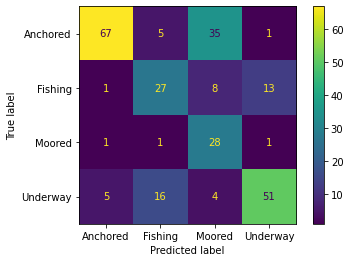

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_labels)
disp.plot()
plt.show()

### Accuracy, Precision, F1, and Recall

In [28]:
print('Precision score:', sklearn.metrics.precision_score(y_true, y_pred, average='macro', labels=image_labels))
print('Accuracy score:', sklearn.metrics.accuracy_score(y_true, y_pred))
print('Recall score:', sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print('F1 score:', sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

Precision score: 0.6506216049073191
Accuracy score: 0.6553030303030303
Recall score: 0.6553030303030303
F1 score: 0.672293148874334


### ROC Curves

ROC AUC score: 0.7896209835071343


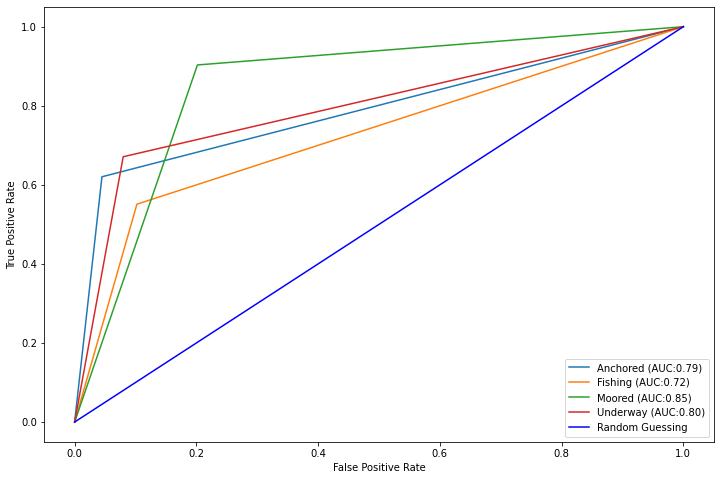

In [29]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(image_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Train transfer learning model - InceptionV3 pretrained model 
We will use pretrained InceptionV3 model and train it on our images.

In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
base_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False) 

87916544/87910968 [==============================] - 1s 0us/step


In [31]:
base_model.trainable = False 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(image_labels), activation='softmax')
# build a new model reusing the pretrained base
model_pt = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model_pt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_pt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [32]:
history_pt = model_pt.fit_generator(train_generator, validation_data=valid_generator, epochs=EPOCHS)

Epoch 1/10
160/160 [==============================] - 17s 108ms/step - loss: 1.1091 - accuracy: 0.5562 - val_loss: 0.9886 - val_accuracy: 0.6353
Epoch 2/10
160/160 [==============================] - 13s 82ms/step - loss: 0.8899 - accuracy: 0.6575 - val_loss: 1.1162 - val_accuracy: 0.6053
Epoch 3/10
160/160 [==============================] - 13s 81ms/step - loss: 0.7727 - accuracy: 0.7070 - val_loss: 0.9016 - val_accuracy: 0.6504
Epoch 4/10
160/160 [==============================] - 13s 81ms/step - loss: 0.7089 - accuracy: 0.7313 - val_loss: 0.9894 - val_accuracy: 0.6410
Epoch 5/10
160/160 [==============================] - 13s 81ms/step - loss: 0.6743 - accuracy: 0.7368 - val_loss: 0.9962 - val_accuracy: 0.6241
Epoch 6/10
160/160 [==============================] - 13s 81ms/step - loss: 0.6465 - accuracy: 0.7510 - val_loss: 0.9481 - val_accuracy: 0.6617
Epoch 7/10
160/160 [==============================] - 13s 82ms/step - loss: 0.6150 - accuracy: 0.7753 - val_loss: 1.2103 - val_accuracy

### Plot accuracy/loss per epoch 

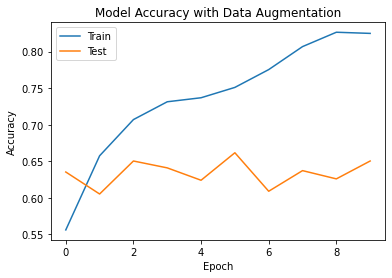

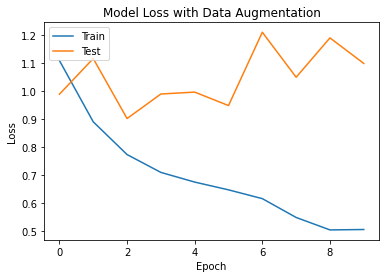

In [33]:
# Plot accuracy/loss simple CNN trained with data augmnetation
plt.plot(history_pt.history['accuracy'])
plt.plot(history_pt.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_pt.history['loss'])
plt.plot(history_pt.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict using pretrained InceptionV3 model trained with image data

In [34]:
# Predict on test data and calculate metrics
import os
y_true = []
y_pred = []

for label in image_labels:  
    # Predict test images of label
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    i = 0
    for f in tc_files:
        fpath = os.path.join(test_imgs_path, f)
        img = load_and_preprocess_image(fpath)
        im_batch = tf.expand_dims(img, 0)
        # make predictions
        batch_pred = model_pt.predict(im_batch) # returns a list of predictions
        pred = batch_pred[0] 
        i = i + 1
        pred_label = image_labels[tf.argmax(pred)]
        y_true.append(label)
        y_pred.append(pred_label)

### Confusion matrix

In [35]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
classification_report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names=image_labels
)
print(classification_report)

              precision    recall  f1-score   support

    Anchored       0.90      0.72      0.80       108
     Fishing       0.77      0.35      0.48        49
      Moored       0.57      0.84      0.68        31
    Underway       0.57      0.82      0.67        76

    accuracy                           0.69       264
   macro avg       0.70      0.68      0.66       264
weighted avg       0.74      0.69      0.69       264



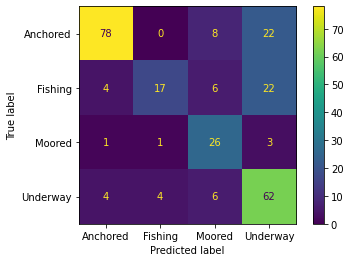

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_labels)
disp.plot()
plt.show()

### Accuracy, Precision, F1, and Recall

In [37]:
print('Precision score:', sklearn.metrics.precision_score(y_true, y_pred, average='macro', labels=image_labels))
print('Accuracy score:', sklearn.metrics.accuracy_score(y_true, y_pred))
print('Recall score:', sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print('F1 score:', sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

Precision score: 0.7008259319047733
Accuracy score: 0.6931818181818182
Recall score: 0.6931818181818182
F1 score: 0.6884105841212116


### ROC Curves

ROC AUC score: 0.788359389664869


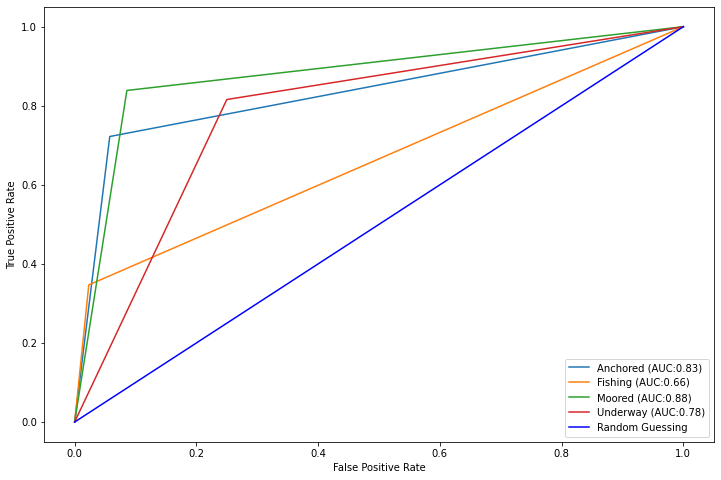

In [38]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(image_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [39]:
history_pt_du = model_pt.fit_generator(train_generator_du, validation_data=valid_generator, epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - 19s 300ms/step - loss: 0.9391 - accuracy: 0.6481 - val_loss: 1.0470 - val_accuracy: 0.6316
Epoch 2/10
64/64 [==============================] - 20s 318ms/step - loss: 0.9039 - accuracy: 0.6551 - val_loss: 0.9290 - val_accuracy: 0.6767
Epoch 3/10
64/64 [==============================] - 18s 288ms/step - loss: 0.8645 - accuracy: 0.6756 - val_loss: 1.1255 - val_accuracy: 0.6410
Epoch 4/10
64/64 [==============================] - 18s 288ms/step - loss: 0.8561 - accuracy: 0.6693 - val_loss: 0.9443 - val_accuracy: 0.6823
Epoch 5/10
64/64 [==============================] - 18s 286ms/step - loss: 0.8404 - accuracy: 0.6779 - val_loss: 1.0308 - val_accuracy: 0.6504
Epoch 6/10
64/64 [==============================] - 19s 289ms/step - loss: 0.8563 - accuracy: 0.6685 - val_loss: 0.9260 - val_accuracy: 0.6617
Epoch 7/10
64/64 [==============================] - 19s 290ms/step - loss: 0.8549 - accuracy: 0.6669 - val_loss: 1.0511 - val_accuracy: 0.6541

## Train transfer learning model - MobileNet V2 pretrained model 
We will use pretrained MobileNet V2 model and train it on our images.

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Input
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                         weights='imagenet', 
                         include_top=False) 

9412608/9406464 [==============================] - 0s 0us/step


In [41]:
base_model.trainable = False 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(image_labels), 
                                         activation='softmax')
# build a new model reusing the pretrained base
model_ptm = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model_ptm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_ptm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [42]:
history_ptm = model_ptm.fit_generator(train_generator, 
                                      validation_data=valid_generator, 
                                      epochs=EPOCHS)

Epoch 1/10
160/160 [==============================] - 7s 47ms/step - loss: 1.0358 - accuracy: 0.5915 - val_loss: 1.0166 - val_accuracy: 0.6147
Epoch 2/10
160/160 [==============================] - 5s 34ms/step - loss: 0.7968 - accuracy: 0.6819 - val_loss: 0.8085 - val_accuracy: 0.7049
Epoch 3/10
160/160 [==============================] - 5s 34ms/step - loss: 0.7048 - accuracy: 0.7290 - val_loss: 0.8096 - val_accuracy: 0.6861
Epoch 4/10
160/160 [==============================] - 6s 34ms/step - loss: 0.6574 - accuracy: 0.7361 - val_loss: 0.8709 - val_accuracy: 0.6692
Epoch 5/10
160/160 [==============================] - 5s 34ms/step - loss: 0.6140 - accuracy: 0.7541 - val_loss: 0.9074 - val_accuracy: 0.6898
Epoch 6/10
160/160 [==============================] - 5s 33ms/step - loss: 0.5711 - accuracy: 0.7832 - val_loss: 0.8389 - val_accuracy: 0.6880
Epoch 7/10
160/160 [==============================] - 5s 33ms/step - loss: 0.5537 - accuracy: 0.7824 - val_loss: 0.9119 - val_accuracy: 0.6711

### Plot accuracy/loss per epoch 

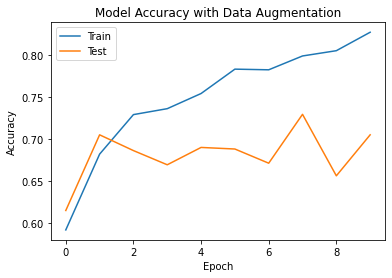

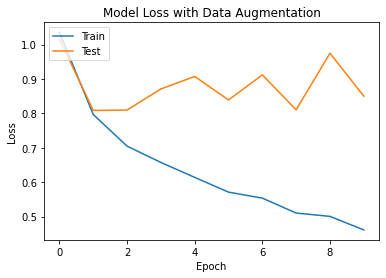

In [43]:
# Plot accuracy/loss simple CNN trained with data augmnetation
plt.plot(history_ptm.history['accuracy'])
plt.plot(history_ptm.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_ptm.history['loss'])
plt.plot(history_ptm.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict using pretrained MobileNetV2 model trained with image data

In [44]:
# Predict on test data and calculate metrics
import os
y_true = []
y_pred = []
y_pred_probs = []

for label in image_labels:  
    # Predict test images of label
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    i = 0
    for f in tc_files:
        fpath = os.path.join(test_imgs_path, f)
        img = load_and_preprocess_image(fpath)
        im_batch = tf.expand_dims(img, 0)
        # make predictions
        batch_pred = model_ptm.predict(im_batch) # returns a list of predictions
        y_pred_probs.append(batch_pred)
        pred = batch_pred[0] 
        i = i + 1
        pred_label = image_labels[tf.argmax(pred)]
        y_true.append(label)
        y_pred.append(pred_label)

### Confusion matrix

In [45]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
classification_report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names=image_labels
)
print(classification_report)

              precision    recall  f1-score   support

    Anchored       0.85      0.76      0.80       108
     Fishing       0.60      0.37      0.46        49
      Moored       0.43      0.84      0.57        31
    Underway       0.77      0.78      0.77        76

    accuracy                           0.70       264
   macro avg       0.66      0.69      0.65       264
weighted avg       0.73      0.70      0.70       264



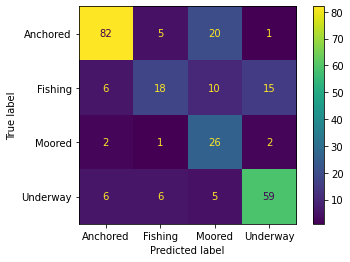

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_labels)
disp.plot()
plt.show()

### Accuracy, Precision, F1, and Recall

In [47]:
print('Precision score:', sklearn.metrics.precision_score(y_true, y_pred, average='macro', labels=image_labels))
print('Accuracy score:', sklearn.metrics.accuracy_score(y_true, y_pred))
print('Recall score:', sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print('F1 score:', sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

Precision score: 0.6616574852742886
Accuracy score: 0.7007575757575758
Recall score: 0.7007575757575758
F1 score: 0.7018513695121872


### ROC Curves

ROC AUC score: 0.793764356071263


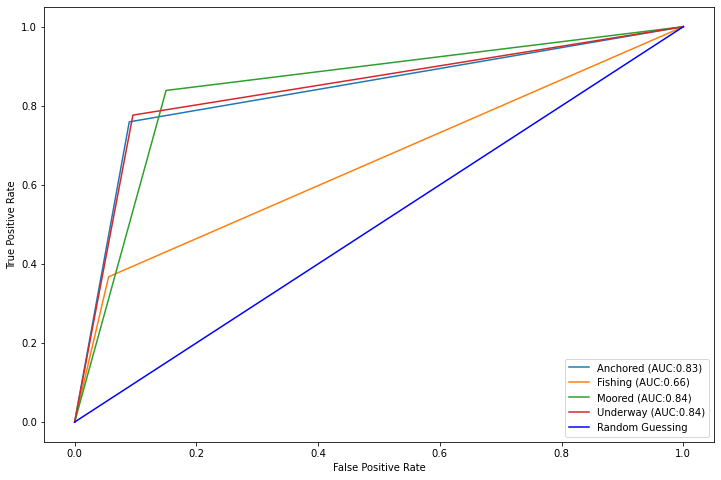

In [48]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(image_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [49]:
history_ptm_du = model_ptm.fit_generator(train_generator_du, 
                                      validation_data=valid_generator, 
                                      epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - 17s 265ms/step - loss: 0.7720 - accuracy: 0.7031 - val_loss: 0.8326 - val_accuracy: 0.7105
Epoch 2/10
64/64 [==============================] - 16s 258ms/step - loss: 0.7449 - accuracy: 0.7070 - val_loss: 0.8616 - val_accuracy: 0.6955
Epoch 3/10
64/64 [==============================] - 16s 256ms/step - loss: 0.7265 - accuracy: 0.7125 - val_loss: 0.9429 - val_accuracy: 0.6729
Epoch 4/10
64/64 [==============================] - 17s 261ms/step - loss: 0.7130 - accuracy: 0.7180 - val_loss: 0.8269 - val_accuracy: 0.7237
Epoch 5/10
64/64 [==============================] - 16s 257ms/step - loss: 0.7255 - accuracy: 0.7164 - val_loss: 0.9343 - val_accuracy: 0.6617
Epoch 6/10
64/64 [==============================] - 17s 262ms/step - loss: 0.7154 - accuracy: 0.7133 - val_loss: 0.9249 - val_accuracy: 0.6880
Epoch 7/10
64/64 [==============================] - 17s 261ms/step - loss: 0.6848 - accuracy: 0.7266 - val_loss: 0.8281 - val_accuracy: 0.7030

In [50]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 3.3 MB/s             


## Train transfer learning model - EfficientNet B0 pretrained model 
We will use pretrained EfficientNet B0 model and train it on our images.

In [51]:
import efficientnet.keras as efn
from tensorflow.keras.layers import Input
base_model = efn.EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False) 

16809984/16804768 [==============================] - 0s 0us/step


In [52]:
base_model.trainable = False 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(image_labels), activation='softmax')
# build a new model reusing the pretrained base
model_pte = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model_pte.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_pte.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [53]:
history_pte = model_pte.fit_generator(train_generator, 
                                      validation_data=valid_generator, 
                                      epochs=EPOCHS)

Epoch 1/10
160/160 [==============================] - 10s 66ms/step - loss: 0.9734 - accuracy: 0.6159 - val_loss: 0.8706 - val_accuracy: 0.6711
Epoch 2/10
160/160 [==============================] - 8s 48ms/step - loss: 0.7915 - accuracy: 0.6874 - val_loss: 0.8685 - val_accuracy: 0.6654
Epoch 3/10
160/160 [==============================] - 8s 49ms/step - loss: 0.7378 - accuracy: 0.7266 - val_loss: 0.7909 - val_accuracy: 0.7274
Epoch 4/10
160/160 [==============================] - 8s 48ms/step - loss: 0.6963 - accuracy: 0.7447 - val_loss: 0.7927 - val_accuracy: 0.7218
Epoch 5/10
160/160 [==============================] - 8s 48ms/step - loss: 0.6841 - accuracy: 0.7392 - val_loss: 0.7608 - val_accuracy: 0.7406
Epoch 6/10
160/160 [==============================] - 8s 48ms/step - loss: 0.6394 - accuracy: 0.7690 - val_loss: 0.7719 - val_accuracy: 0.7444
Epoch 7/10
160/160 [==============================] - 8s 48ms/step - loss: 0.6242 - accuracy: 0.7753 - val_loss: 0.7506 - val_accuracy: 0.738

### Plot accuracy/loss per epoch 

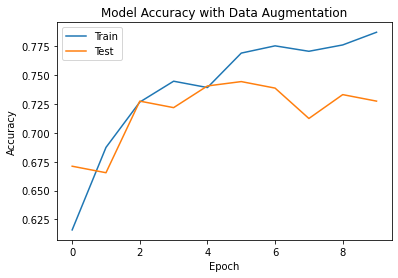

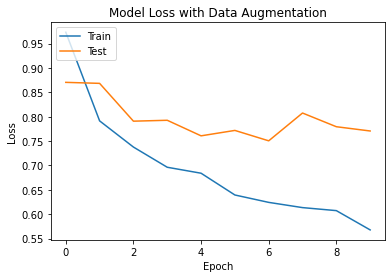

In [54]:
# Plot accuracy/loss simple CNN trained with data augmnetation
plt.plot(history_pte.history['accuracy'])
plt.plot(history_pte.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_pte.history['loss'])
plt.plot(history_pte.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict using pretrained EfficientNet B0 model trained with image data

In [55]:
# Predict on test data and calculate metrics
import os
y_true = []
y_pred = []
y_pred_probs = []

for label in image_labels:  
    # Predict test images of label
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    i = 0
    for f in tc_files:
        fpath = os.path.join(test_imgs_path, f)
        img = load_and_preprocess_image(fpath)
        im_batch = tf.expand_dims(img, 0)
        # make predictions
        batch_pred = model_pte.predict(im_batch) # returns a list of predictions
        y_pred_probs.append(batch_pred)
        pred = batch_pred[0] 
        i = i + 1
        pred_label = image_labels[tf.argmax(pred)]
        y_true.append(label)
        y_pred.append(pred_label)

### Confusion matrix

In [56]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
classification_report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names=image_labels
)
print(classification_report)

              precision    recall  f1-score   support

    Anchored       0.91      0.81      0.85       108
     Fishing       0.60      0.43      0.50        49
      Moored       0.50      0.90      0.64        31
    Underway       0.78      0.79      0.78        76

    accuracy                           0.74       264
   macro avg       0.70      0.73      0.70       264
weighted avg       0.77      0.74      0.74       264



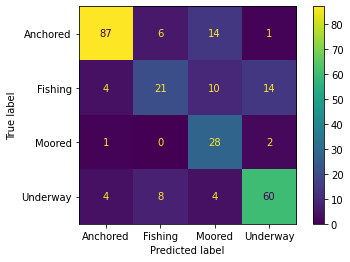

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_labels)
disp.plot()
plt.show()

### Accuracy, Precision, F1, and Recall

In [58]:
print('Precision score:', sklearn.metrics.precision_score(y_true, y_pred, average='macro', labels=image_labels))
print('Accuracy score:', sklearn.metrics.accuracy_score(y_true, y_pred))
print('Recall score:', sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print('F1 score:', sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

Precision score: 0.6963676948051949
Accuracy score: 0.7424242424242424
Recall score: 0.7424242424242424
F1 score: 0.7431042166082733


### ROC Curves

ROC AUC score: 0.8241775852865515


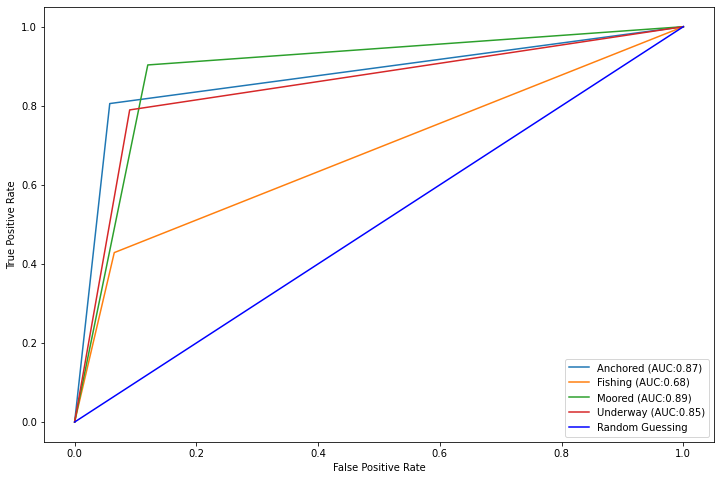

In [59]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(image_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [60]:
history_pte_du = model_pte.fit_generator(train_generator_du, 
                                      validation_data=valid_generator, 
                                      epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - 17s 272ms/step - loss: 0.7313 - accuracy: 0.7203 - val_loss: 0.7790 - val_accuracy: 0.7218
Epoch 2/10
64/64 [==============================] - 17s 266ms/step - loss: 0.7208 - accuracy: 0.7156 - val_loss: 0.8036 - val_accuracy: 0.7124
Epoch 3/10
64/64 [==============================] - 17s 268ms/step - loss: 0.6911 - accuracy: 0.7306 - val_loss: 0.7894 - val_accuracy: 0.7143
Epoch 4/10
64/64 [==============================] - 17s 272ms/step - loss: 0.6995 - accuracy: 0.7203 - val_loss: 0.7846 - val_accuracy: 0.7218
Epoch 5/10
64/64 [==============================] - 17s 266ms/step - loss: 0.6790 - accuracy: 0.7353 - val_loss: 0.8273 - val_accuracy: 0.7124
Epoch 6/10
64/64 [==============================] - 17s 264ms/step - loss: 0.6808 - accuracy: 0.7463 - val_loss: 0.8146 - val_accuracy: 0.7162
Epoch 7/10
64/64 [==============================] - 18s 274ms/step - loss: 0.6833 - accuracy: 0.7368 - val_loss: 0.7883 - val_accuracy: 0.7180

### Model Comparision
We trained for 10 epochs for all models and compared validation accuracy and other metrics.

#### Models and Number of Parameters

| Model | Number of Parameters |
| --- | :---: |
| Simple CNN | 3,065,124 | 
| Inception V3 pre-trained model | 21,810,980 |
| MobileNet V2 pre-trained model | 2,263,108 |
| EfficientNet B0 pre-trained model | 4,054,688 |


#### Validation accuracy

In [1]:
print('* - with augmented data')

* - with augmented data


| Model | Validation Accuracy |Validation Accuracy (*) |
| --- | :---: | :---: |
| Simple CNN | 0.6109 | 0.6165 |
| Inception V3 pre-trained model | 0.6504 | 0.6560
| MobileNet V2 pre-trained model | 0.7049 | 0.7124 
| EfficientNet B0 pre-trained model | 0.7274 | 0.7105

#### Test accuracy measures

| Model | Precison Score | Accuracy Score | Recall Score | F1 Score |
| --- | --- | --- | --- | --- |
| Simple CNN | 0.6247 | 0.6590 | 0.6590 | 0.6640
| Inception V3 pre-trained model | 0.7008 | 0.6932 | 0.6932 | 0.6884
| MobileNet V2 pre-trained model | 0.6616 | 0.7007 | 0.7007 | 0.7018
| EfficientNet B0 pre-trained model | 0.6964 | 0.7424 | 0.7424 | 0.7431

## Demo of classifying/predicting a Vessel mobility pattern

Actual label is Moored. Images and model predictions:


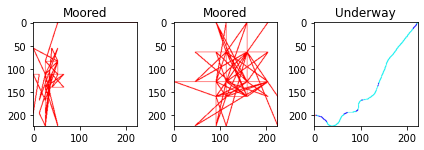

In [69]:
# Predict test images of Moored
test_imgs_path = test_dir + '/Moored/'
tc_files = os.listdir(test_imgs_path)
print('Actual label is Moored. Images and model predictions:')
fig=plt.figure()
cols = 3
i = 0
for f in tc_files:
  fpath = os.path.join(test_imgs_path, f)
  img = load_and_preprocess_image(fpath)
  im_batch = tf.expand_dims(img, 0)
  # make predictions
  batch_pred = model_pte.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 
  i = i + 1
  fig.add_subplot(1, cols, i)
  plt.imshow(img)
  plt.title(image_labels[tf.argmax(pred)])
  if i>2:
    break

fig.tight_layout()    
plt.show()

Actual label is Fishing. Images and model predictions:


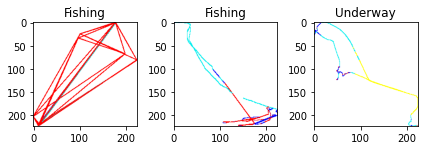

In [70]:
# Predict test images of Fishing
test_imgs_path = test_dir + '/Fishing/'
tc_files = os.listdir(test_imgs_path)
print('Actual label is Fishing. Images and model predictions:')
fig=plt.figure()
cols = 3
i = 0
for f in tc_files:
  fpath = os.path.join(test_imgs_path, f)
  img = load_and_preprocess_image(fpath)
  im_batch = tf.expand_dims(img, 0)
  # make predictions
  batch_pred = model_pte.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 
  i = i + 1
  fig.add_subplot(1, cols, i)
  plt.imshow(img)
  plt.title(image_labels[tf.argmax(pred)])
  if i>2:
    break

fig.tight_layout()    
plt.show()

Actual label is Anchored. Images and model predictions:


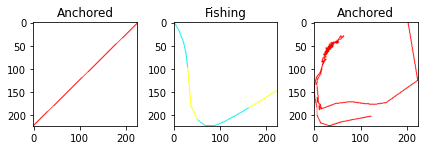

In [72]:
# Predict test images of Achored
test_imgs_path = test_dir + '/Anchored/'
tc_files = os.listdir(test_imgs_path)
print('Actual label is Anchored. Images and model predictions:')
fig=plt.figure()
cols = 3
i = 0
for f in tc_files:
  fpath = os.path.join(test_imgs_path, f)
  img = load_and_preprocess_image(fpath)
  im_batch = tf.expand_dims(img, 0)
  # make predictions
  batch_pred = model_pte.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 
  i = i + 1
  fig.add_subplot(1, cols, i)
  plt.imshow(img)
  plt.title(image_labels[tf.argmax(pred)])
  if i>2:
    break

fig.tight_layout()    
plt.show()

Actual label is Underway. Images and model predictions:


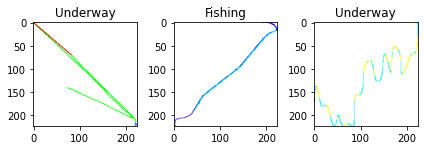

In [73]:
# Predict test images of Underway
test_imgs_path = test_dir + '/Underway/'
tc_files = os.listdir(test_imgs_path)
print('Actual label is Underway. Images and model predictions:')
fig=plt.figure()
cols = 3
i = 0
for f in tc_files:
  fpath = os.path.join(test_imgs_path, f)
  img = load_and_preprocess_image(fpath)
  im_batch = tf.expand_dims(img, 0)
  # make predictions
  batch_pred = model_pte.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 
  i = i + 1
  fig.add_subplot(1, cols, i)
  plt.imshow(img)
  plt.title(image_labels[tf.argmax(pred)])
  if i>2:
    break

fig.tight_layout()    
plt.show()